In [1]:
import pandas as pd
import numpy as np
import shap

import sklearn

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import bhtsne

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

shap.initjs()

<h2> Data Loading and Preprocessing </h2>

In [2]:
counts = pd.read_csv('/Users/vincentliu/Desktop/PeerLab/SCRAS/Data/pbmc_4k_dense.csv', index_col=0)
counts = counts.astype(np.int32)

<h3> Cell and Gene Filtering </h3>

(3958, 17357)


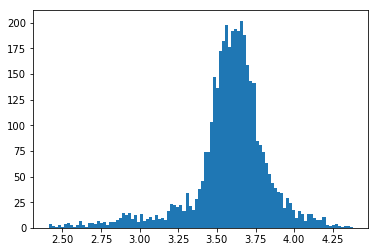

In [3]:
ms = np.log10( counts.sum(axis=1) )

# Figure
plt.hist(ms, 100)
print(counts.shape)

In [4]:
# Cells passing the threshold
ms = counts.sum(axis = 1)
use_cells = ms.index[np.log10(ms) > 3]

# Remove zero sum genes
use_genes = counts.columns[counts.loc[use_cells,:].sum() > 0]

# Update counts
counts = counts.loc[use_cells, use_genes]

(3788, 17332)


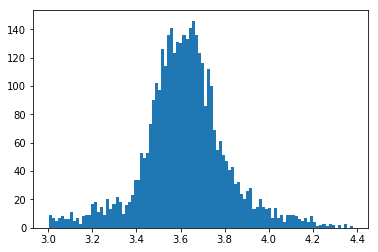

In [5]:
# Figure
ms = np.log10(counts.sum(axis=1))
plt.hist(ms, 100)
print(counts.shape)

In [6]:
ms = counts.sum(axis=1)
norm_df = counts.div(ms, axis=0).mul(np.median(ms), axis=0)  # normalization based on median

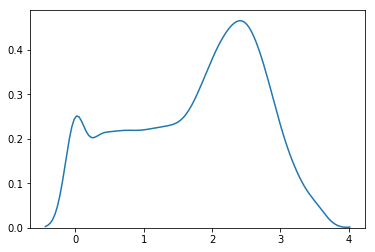

In [7]:
# Visualize gene distribution
gene_counts = (norm_df > 0).sum()
plt.figure()
sns.kdeplot(np.log10(gene_counts))

In [8]:
use_genes = gene_counts.index[gene_counts > 10]
percent = len(use_genes) / len(gene_counts)
print("percent genes used: {}".format(str(percent)))

counts = counts.loc[:, use_genes]
norm_df = norm_df.loc[:, use_genes]
log_df = np.log2(norm_df+0.1)

percent genes used: 0.7334410339256866


<h2> Dimensionality Reduction </h2>

<h3> PCA </h3>

In [10]:
pca = PCA(n_components=10, svd_solver='randomized')
pcaproj = pd.DataFrame(pca.fit_transform(norm_df), index=norm_df.index)
print(np.sum(pca.explained_variance_ratio_))

0.774243178212


<h3> tSNE </h3>

In [12]:
from copy import deepcopy

data = deepcopy(norm_df)
tsne = pd.DataFrame(bhtsne.tsne(data, perplexity=150), index=data.index, columns=['x', 'y'])

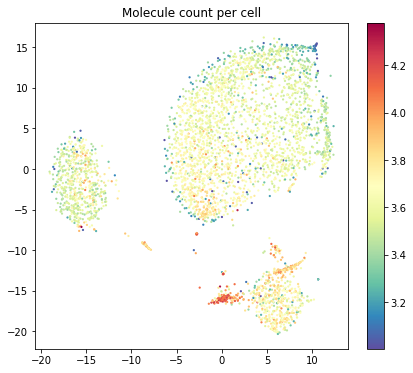

In [13]:
# Library size plot
plt.figure(figsize=[7, 6])
plt.scatter(tsne['x'], tsne['y'], s=5, edgecolors='none',
    cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[tsne.index]))
plt.colorbar()
plt.title("Molecule count per cell")

<h2> Clustering </h2>

In [16]:
import phenograph

# Cluster and cluster centrolds
communities, graph, Q = phenograph.cluster(pcaproj, k=200)
communities = pd.Series(communities, index=pcaproj.index)

Finding 200 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12556791305541992 seconds
Jaccard graph constructed in 9.352593898773193 seconds
Wrote graph to binary file in 1.4242160320281982 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.744544
After 13 runs, maximum modularity is Q = 0.745624
Louvain completed 33 runs in 6.257678985595703 seconds
PhenoGraph complete in 17.281748056411743 seconds


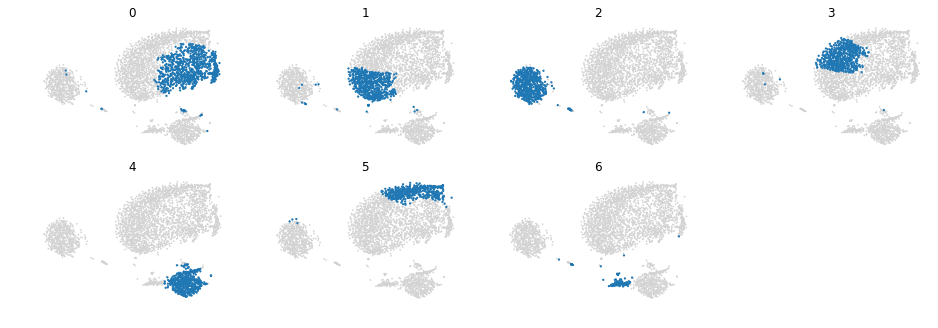

In [17]:
# Best prediction
fig = plt.figure(figsize=[4*4, 2*4])

for i, cluster in enumerate(set(communities)):
    cells = communities.index[communities == cluster]
    
    ax = fig.add_subplot(3, 4, i+1)
    ax.scatter(tsne['x'], tsne['y'], 
        s=3, edgecolors='none', color='lightgrey')        
    ax.scatter(tsne.loc[cells, 'x'], tsne.loc[cells,'y'], 
        s=5, edgecolors='none')

    # Clean up
    ax.set_axis_off()
    ax.set_title(cluster)
    sns.despine()

In [46]:
def plot_genes(exp_mat, tsne_data, genes, title):
    # Set up figure grid
    n = len(genes); max_cols = 5
    nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
    
    fig = plt.figure(figsize=[6 * ncols, 4*nrows])
    for i, gene in enumerate(genes):
        ax = fig.add_subplot(nrows, ncols, i+1)
        ax.scatter(tsne_data.loc[:, 'x'], tsne_data.loc[:, 'y'], s=3,
                   cmap=matplotlib.cm.Spectral_r, c=exp_mat.loc[tsne_data.index, gene])
        ax.set_title(gene)
        ax.set_axis_off()
    plt.suptitle(title)

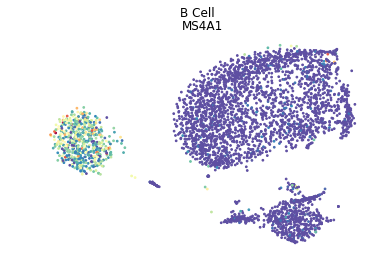

In [47]:
plot_genes(norm_df, tsne, ['MS4A1'], 'B Cell')

<h2> Explain using Cluster Labels </h2>

In [20]:
# 0 if not in cluster 2, 1 otherwise
clus_binary = [0 if x != 2 else 1 for x in communities]

In [22]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(pcaproj, clus_binary)
f = lambda x: knn.predict_proba(pca.transform(x))[:,1]

In [26]:
X_rep = shap.kmeans(pcaproj, 10)
explainer = shap.KernelExplainer(f, X_rep)
shap_values_single = explainer.shap_values(pcaproj.iloc[0,:], nsamples=1000)
shap.force_plot(shap_values_single, pcaproj)

Provided model function fails when applied to the provided data set.


ValueError: operands could not be broadcast together with shapes (10,10) (12712,) 